In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [2]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


# Exercise 1

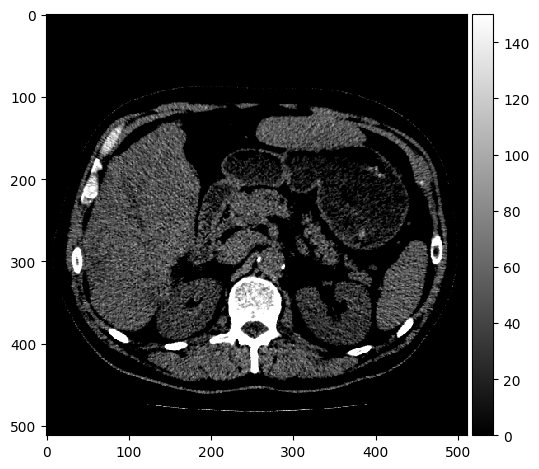

In [3]:
io.imshow(img, vmin=0, vmax=150, cmap='gray')
io.show()

# Exercise 2

In [4]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

# Calculate average and standard deviation of spleen values
spleen_mean = np.mean(spleen_values)
spleen_std = np.std(spleen_values)

# Print the results
print('Mean:', spleen_mean)
print('Standard deviation:', spleen_std)

Mean: 49.48026905829597
Standard deviation: 14.9970794143059


Yes they correspond to the values above

# Exercise 3

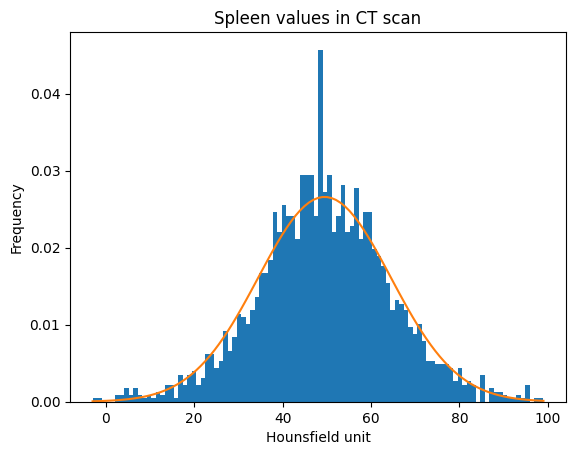

In [5]:
n, bins, patches = plt.hist(spleen_values, 100, density=1)
pdf_spleen = norm.pdf(bins, spleen_mean, spleen_std)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

They look gaussian distributed

# Exercise 4

In [6]:
def values_from_mask(img, mask_file):
    roi = io.imread(in_dir + mask_file)
    # convert to boolean image
    mask = roi > 0
    return img[mask]

In [7]:
bone_values = values_from_mask(img, 'BoneROI.png')
fat_values = values_from_mask(img, 'FatROI.png')
liver_values = values_from_mask(img, 'LiverROI.png')
kidney_values = values_from_mask(img, 'KidneyROI.png')

mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

mu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)

mu_fat = np.mean(fat_values)
std_fat = np.std(fat_values)

mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)

mu_kidney = np.mean(kidney_values)
std_kidney = np.std(kidney_values)

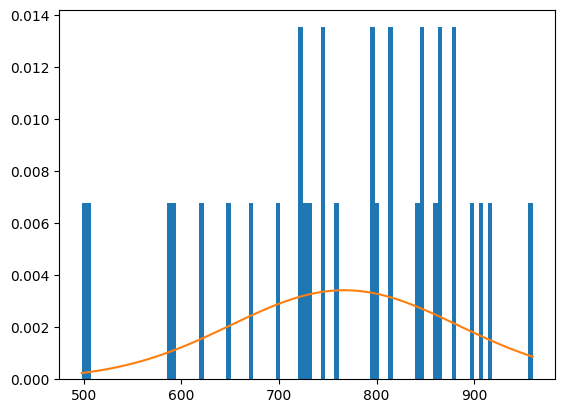

In [8]:
mean = np.mean(bone_values)
std = np.std(bone_values)
n, bins, patches = plt.hist(bone_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

Not gaussian ^

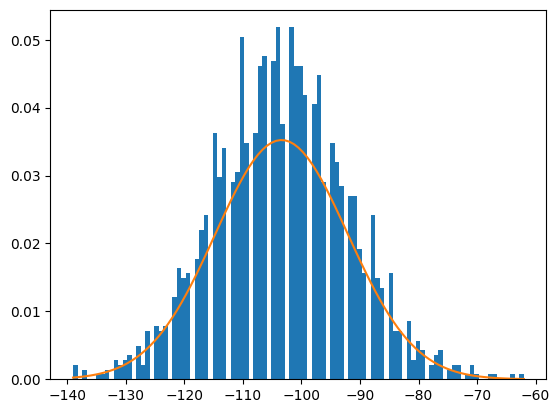

In [9]:
mean = np.mean(fat_values)
std = np.std(fat_values)
n, bins, patches = plt.hist(fat_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

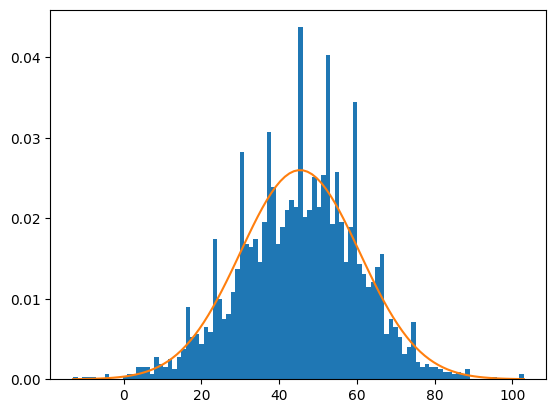

In [10]:
mean = np.mean(liver_values)
std = np.std(liver_values)
n, bins, patches = plt.hist(liver_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

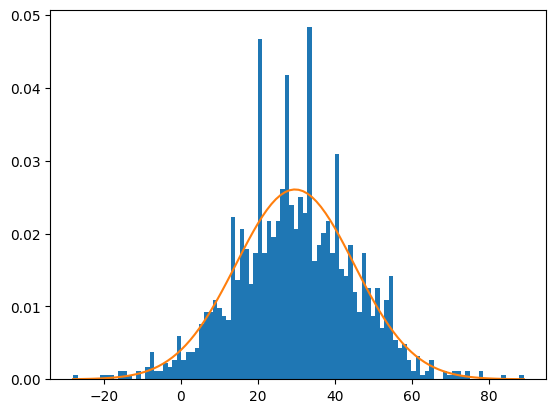

In [11]:
mean = np.mean(kidney_values)
std = np.std(kidney_values)
n, bins, patches = plt.hist(kidney_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

# Exercise 5

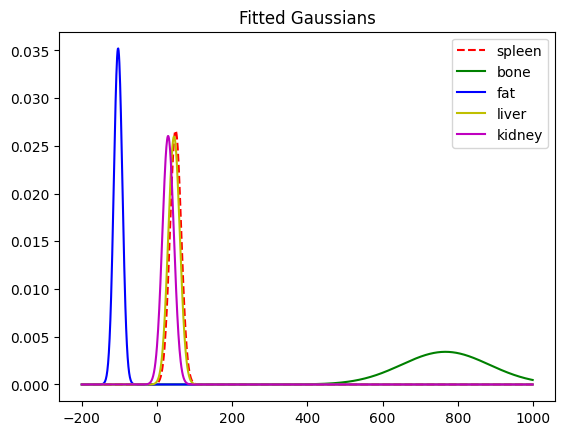

In [12]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)
pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_fat, 'b', label="fat")
plt.plot(hu_range, pdf_liver, 'y', label="liver")
plt.plot(hu_range, pdf_kidney, 'm', label="kidney")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

Fat and bone are easy to seperate. Kidney, spleen and liver will be hard since they are ontop of each other

# Exercise 6

We can make the classes fat, bone, and organs. Organs will be liver, kidney and spleen combined.

# Exercise 7

In [13]:
soft_tissue = np.append(spleen_values, liver_values)
soft_tissue = np.append(soft_tissue, kidney_values)
mu_soft = np.mean(soft_tissue)
std_soft = np.std(soft_tissue)

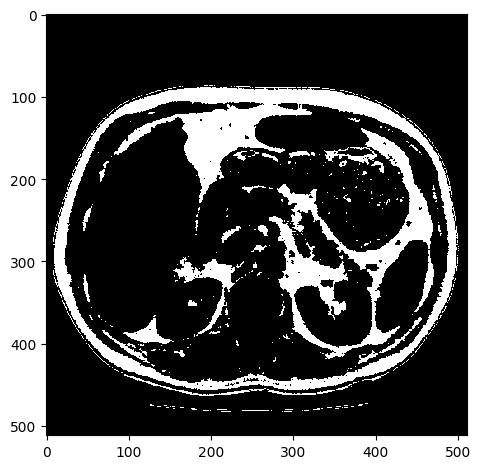

In [14]:
t_background = -200

# Find midpoint between fat and soft tissue
t_fat_soft = (mu_fat + mu_soft) / 2

# Combine spleen, liver and kidney values into new value called soft tissue
fat_img = (img > t_background) & (img <= t_fat_soft)
io.imshow(fat_img, cmap='gray')
io.show()

# Exercise 8

In [15]:
t_soft_bone = (mu_soft + mu_bone) / 2
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone

# Exercise 9A

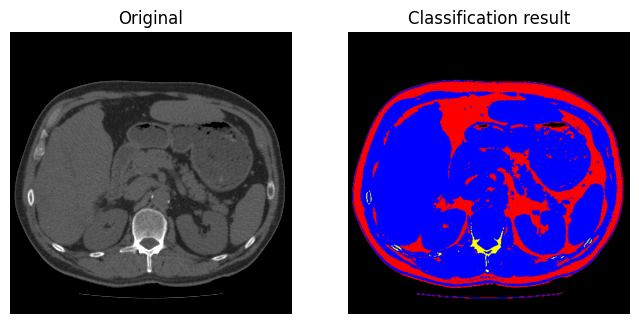

In [16]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

# Exercise 9B

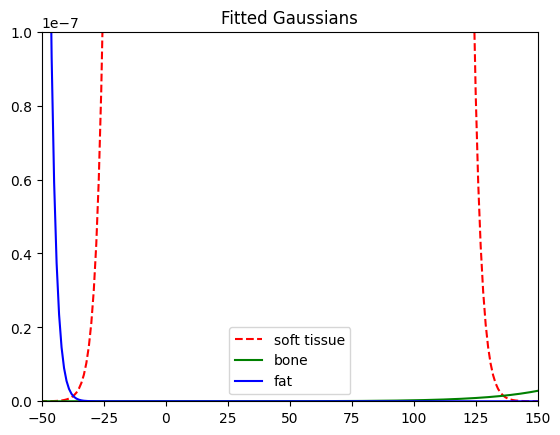

In [17]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_soft = norm.pdf(hu_range, mu_soft, std_soft)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
plt.plot(hu_range, pdf_spleen, 'r--', label="soft tissue")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_fat, 'b', label="fat")
plt.title("Fitted Gaussians")
plt.legend()
plt.ylim(0, 0.0000001)
plt.xlim(-50, 150)
plt.show()

In [18]:
# The intersection seems to be around -38 HU for fat/soft and 138 for soft/bone
t_fat_soft = -38
t_soft_bone = 138

# Exercise 10

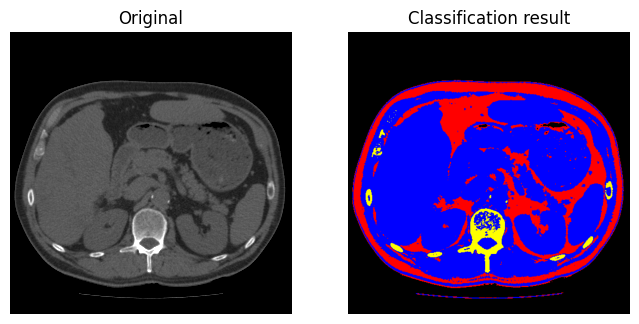

In [19]:
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone

label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

This looks much better, and is accurately getting the bones

# Exercise 11A

In [20]:
for i in range(-50, 200, 1):
    if norm.pdf(i, mu_soft, std_soft) > norm.pdf(i, mu_bone, std_bone):
        t_soft_bone = i

for i in range(-50, 200, 1):
    if norm.pdf(i, mu_soft, std_soft) < norm.pdf(i, mu_fat, std_fat):
        t_fat_soft = i

print(t_fat_soft, t_soft_bone)

-45 140


# Exercise 11B

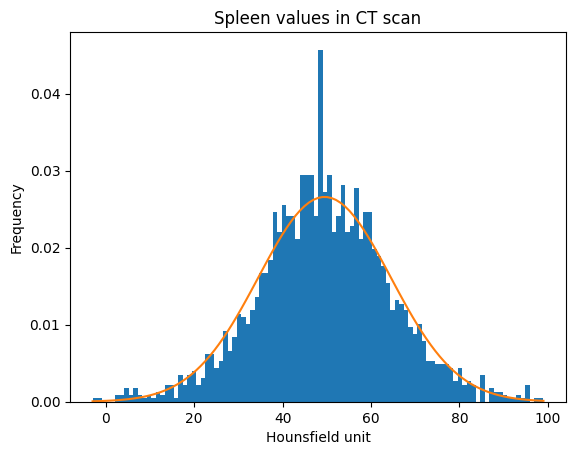

In [21]:
n, bins, patches = plt.hist(spleen_values, 100, density=1)
pdf_spleen = norm.pdf(bins, spleen_mean, spleen_std)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

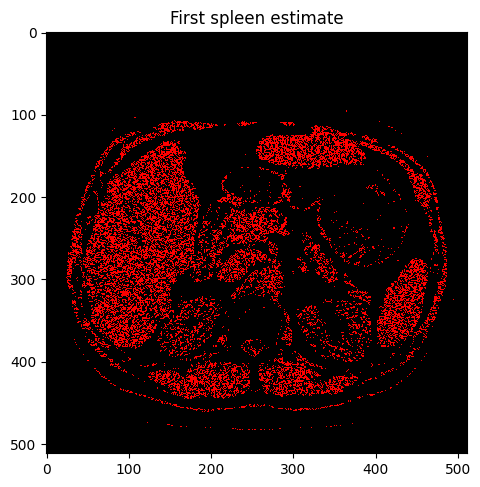

In [22]:
t_1 = 40
t_2 = 60

spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

# Exercise 12

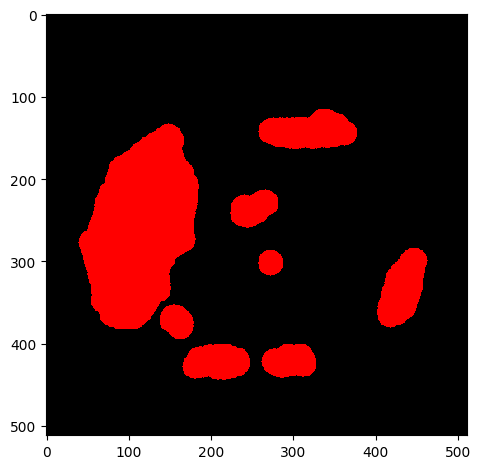

In [23]:
footprint = disk(3)
closed = binary_closing(spleen_estimate, footprint)

footprint = disk(15)
opened = binary_opening(closed, footprint)

spleen_label_colour = color.label2rgb(opened)
io.imshow(spleen_label_colour)

# Exercise 12

Number of labels: 8


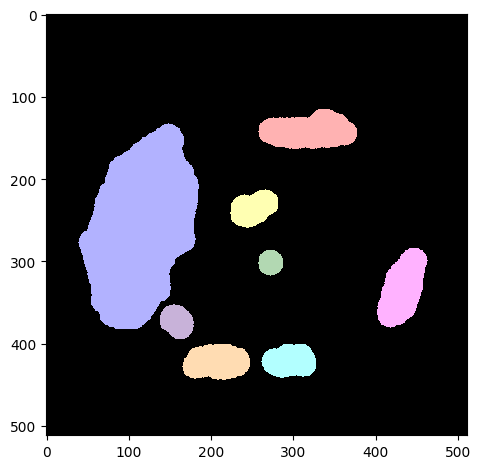

In [24]:
label_img = measure.label(opened)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

label2rgb_img = label2rgb(label_img, image=opened)
io.imshow(label2rgb_img)

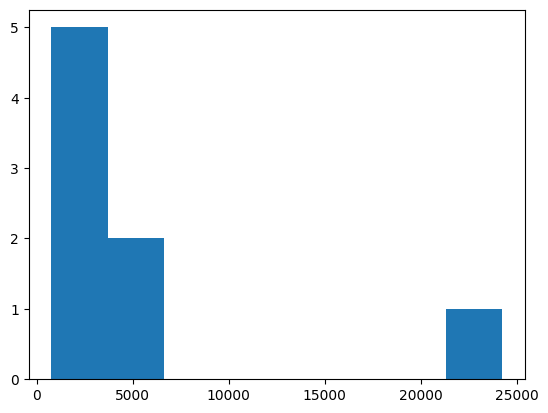

In [25]:

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=8)
plt.show()

# Exercise 13
The spleen is nicely separated

# Exercise 14


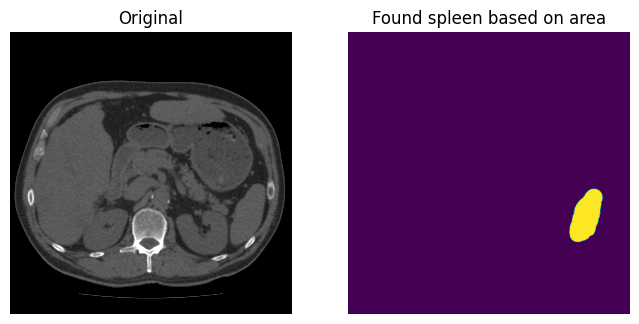

In [26]:
min_area = 3000
max_area = 4000

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img, i_area, 'Found spleen based on area')

# Exercise 15

In [27]:
def spleen_finder(ct_image):
    t_1, t_2 = 20, 80
    spleen_estimate = (ct_image > t_1) & (ct_image < t_2)
    
    #  morphological operations 
    fp1, fp2 = disk(2), disk(4)
    closed = binary_closing(spleen_estimate, fp1)
    opened = binary_opening(closed, fp2)

    # image to label
    label_img = measure.label(opened)
    region_props = measure.regionprops(label_img)

    min_area = 2000
    max_area = 10000 
    min_ecc = 0.90
    max_perimeter = 350 

    for region in region_props:
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or region.eccentricity < min_ecc or region.perimeter > max_perimeter:
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
                
    i_area = label_img_filter > 0
    show_comparison(img, i_area, 'Found spleen based on area')
    return i_area

# Exercise 16

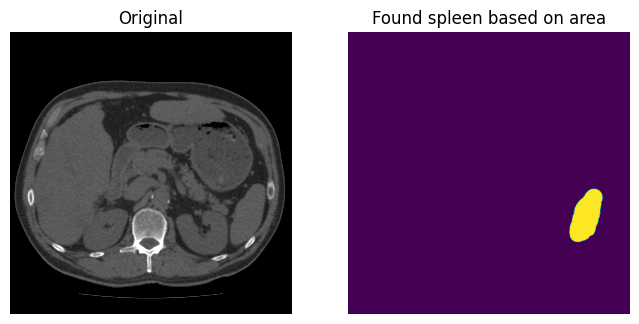

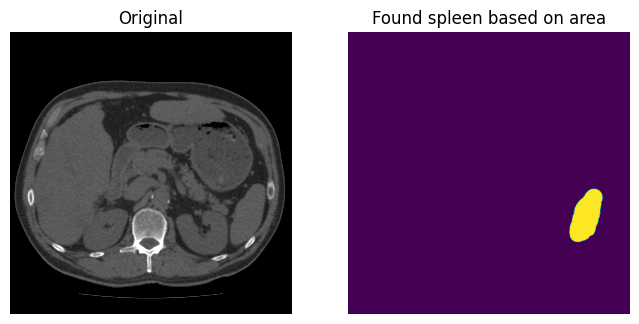

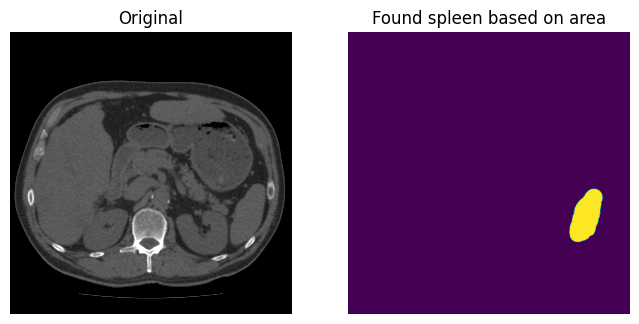

In [28]:
# Validation 1
ct = dicom.read_file(in_dir + 'Validation1.dcm')
val1 = ct.pixel_array

# Validation 2
ct = dicom.read_file(in_dir + 'Validation2.dcm')
val2 = ct.pixel_array

# Validation 3
ct = dicom.read_file(in_dir + 'Validation3.dcm')
val3 = ct.pixel_array


spleen1 = spleen_finder(val1)
spleen2 = spleen_finder(val2)
spleen3 = spleen_finder(val3)

I found too many in the first validation, and too few in the second

# Exercise 17

In [31]:
ground_truth_img = io.imread(in_dir + 'Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen1.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.9425033713375015


In [32]:
ground_truth_img = io.imread(in_dir + 'Validation2_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen2.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.8707726763717805


In [33]:
ground_truth_img = io.imread(in_dir + 'Validation3_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen3.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.8579295154185023
